In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Step 1: Load Zomato stock data
zomato = yf.download('ZOMATO.NS', start='2021-07-01', end='2025-06-01')  # Adjust date range as needed
df = zomato[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close
Ticker,ZOMATO.NS
Date,
2021-07-23,126.000000
2021-07-26,140.649994
2021-07-27,132.899994
2021-07-28,131.199997
2021-07-29,141.550003
...,...
2025-05-26,226.800003
2025-05-27,224.789993


In [4]:
# Step 2: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [5]:
# Step 3: Create sequences
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [6]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape input to [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [7]:
# Step 4: Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\punee\anaconda3n\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Step 5: Train the model
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0627
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0033
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0019
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0014
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0013
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0013
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0013
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0012
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0013
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0011


In [9]:
# Step 6: Predict next 30 days
input_sequence = scaled_data[-time_step:]
predictions = []
for _ in range(30):
    input_reshaped = input_sequence.reshape(1, time_step, 1)
    pred_scaled = model.predict(input_reshaped, verbose=0)
    predictions.append(pred_scaled[0, 0])
    input_sequence = np.append(input_sequence[1:], pred_scaled, axis=0)

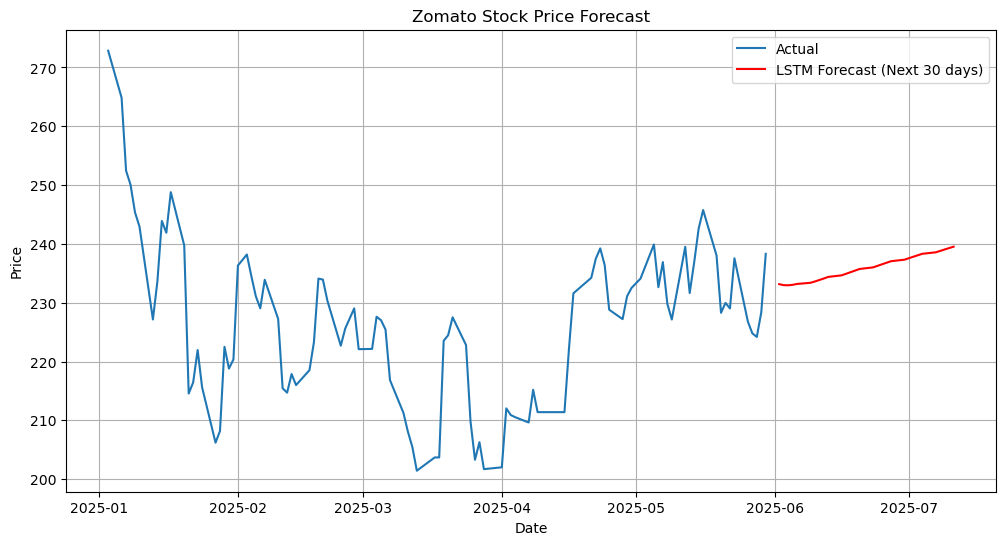

In [10]:
# Inverse transform predictions
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Step 7: Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label='Actual')
future_dates = pd.date_range(df.index[-1], periods=31, freq='B')[1:]
plt.plot(future_dates, predicted_prices, label='LSTM Forecast (Next 30 days)', color='red')
plt.title('Zomato Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
